In [1]:
import os, sys, warnings, random, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
df = pd.DataFrame(pd.read_csv('../data/processed/resent20_predicted_final.csv'))

In [3]:
df.head(1)

,player_name,avg_player_assists,avg_player_dbno,avg_player_dist_ride,avg_player_dist_walk,avg_player_dmg,avg_player_kills,avg_player_survive_time,avg_team_placement,victim_time,victim_position_x,victim_position_y,cluster_id
0,GoochSlapper69,0.65,1.4,1327.600281,1255.181354,223.6,2.05,834.33835,18.55,92,466214.9,641051.5,2


In [4]:
player_df = df.drop(columns=['player_name',	'victim_position_x', 'victim_position_y'])
player_df.columns

Index(['avg_player_assists', 'avg_player_dbno', 'avg_player_dist_ride',
       'avg_player_dist_walk', 'avg_player_dmg', 'avg_player_kills',
       'avg_player_survive_time', 'avg_team_placement', 'victim_time',
       'cluster_id'],
      dtype='object')

In [9]:
for c in player_df.columns:
    print(c, player_df[c].max())

avg_player_assists 8.0
avg_player_dbno 22.0
avg_player_dist_ride 15476.6133
avg_player_dist_walk 6942.377
avg_player_dmg 3244.0
avg_player_kills 32.0
avg_player_survive_time 9092554457.987
avg_team_placement 100.0
victim_time 420
cluster_id 38


In [5]:
player_df = player_df.astype({
    'avg_player_assists': 'float16',
    'avg_player_dbno': 'float16',
    'avg_player_dist_ride': 'uint32',
    'avg_player_dist_walk': 'uint32',
    'avg_player_dmg': 'uint16',
    'avg_player_kills': 'float16',
    'avg_player_survive_time': 'uint16', 
    'avg_team_placement': 'uint8',
    'victim_time': 'uint16',
    'cluster_id': 'category'
})

In [11]:
player_df.columns

Index(['avg_player_assists', 'avg_player_dbno', 'avg_player_dist_ride',
       'avg_player_dist_walk', 'avg_player_dmg', 'avg_player_kills',
       'avg_player_survive_time', 'avg_team_placement', 'victim_time',
       'cluster_id'],
      dtype='object')

AUC: 0.6529
Accuracy: 0.6311
Confusion Matrix:
[[278407 436041]
 [184208 782883]]

Classification Report:
              precision    recall  f1-score   support

       False     0.6018    0.3897    0.4731    714448
        True     0.6423    0.8095    0.7163    967091

    accuracy                         0.6311   1681539
   macro avg     0.6220    0.5996    0.5947   1681539
weighted avg     0.6251    0.6311    0.6129   1681539



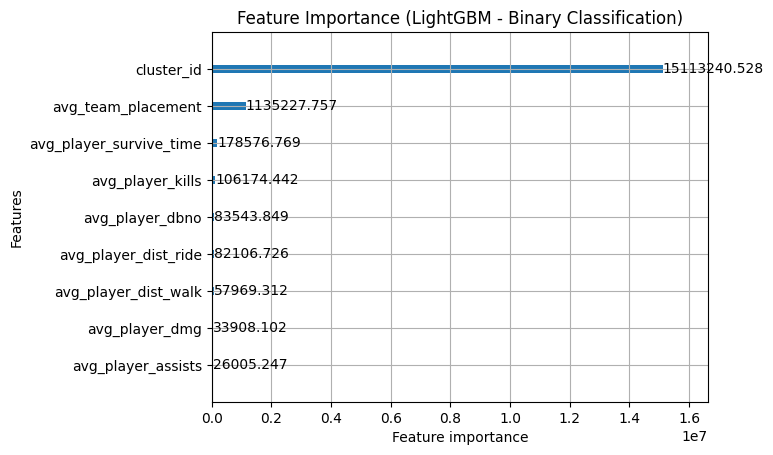

LightGBM 로그 기록 완료: lgbm_experiment_log.jsonl


In [ ]:
#-------------------------------------------------
# LightGBM (180초)
#-------------------------------------------------
import json
from datetime import datetime

import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score




# 타깃은 생존여부
target = 'survived'

# (180초) 이내 사망 여부를 타깃으로 변환
time = 180
player_df[target] = (player_df["victim_time"] >= time).astype(bool)

features = [col for col in player_df.columns if col not in ['victim_time', target]]

X = player_df[features]
y = player_df[target]


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dataset 구성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)


# 모델 파라미터 설정
params = {
    "objective": "binary",          
    "metric": "auc",                # 라벨별 불균형이 클 때 AUC 사용
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 50,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "verbose": -1,
    "max_depth": 7, 
    "early_stopping_round": 100
}


# 모델 학습
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000
)

# 예측 및 평가
# LightGBM의 predict()는 확률값(0~1)을 반환함
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

# 지표 출력
auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

#------------------------------
# Feature Importance 시각화
#------------------------------
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.title("Feature Importance (LightGBM - Binary Classification)")
plt.show()



#-----------------------------------
# 로그
#-------------------------------

# 평가
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_prob)
}

# 엔트리 구성
log_entry = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "params": params,
    "metrics": metrics
}

# JSON 들여쓰기
log_path = "lgbm_experiment_log.jsonl"
with open(log_path, "a", encoding="utf-8") as f:
    f.write(json.dumps(log_entry, ensure_ascii=False) + "\n")

print(f"LightGBM 로그 기록 완료: {log_path}")

joblib.dump(model, "lgbm_model.pkl")

In [ ]:
#-------------------------------------------------
# LightGBM (180초)
#-------------------------------------------------
import json
from datetime import datetime

import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score




# 타깃은 사망여부
target = 'dead'

# (180초) 이내 사망 여부를 타깃으로 변환
time = 180
player_df[target] = (player_df["victim_time"] <= time).astype(bool)

features = [col for col in player_df.columns if col not in ['victim_time', target]]

X = player_df[features]
y = player_df[target]


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dataset 구성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)


# 모델 파라미터 설정
params = {
    "objective": "binary",          
    "metric": "auc",                # 라벨별 불균형이 클 때 AUC 사용
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 50,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "verbose": -1,
    "max_depth": 5, 
    "early_stopping_round": 100
}


# 모델 학습
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=4000
)

# 예측 및 평가
# LightGBM의 predict()는 확률값(0~1)을 반환함
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

# 지표 출력
auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

#------------------------------
# Feature Importance 시각화
#------------------------------
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.title("Feature Importance (LightGBM - Binary Classification)")
plt.show()



#-----------------------------------
# 로그
#-------------------------------

# 평가
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_prob)
}

# 엔트리 구성
log_entry = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "params": params,
    "metrics": metrics
}

# JSON 들여쓰기
log_path = "lgbm_experiment_log.jsonl"
with open(log_path, "a", encoding="utf-8") as f:
    f.write(json.dumps(log_entry, ensure_ascii=False) + "\n")

print(f"LightGBM 로그 기록 완료: {log_path}")

joblib.dump(model, "lgbm_model.pkl")